## Robot Tracking via Particle Filter

Track a robot through a maze with a particle filter and visualise the results

In [1]:
%load_ext autoreload
%autoreload 1
%aimport particle.map
%aimport particle.filter

from enum import Enum
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
from os.path import abspath, dirname, join
import particle.filter as fl
import particle.map as mp
import scipy.ndimage.morphology as morph
import time

# Get useful paths
paths = mp.get_paths()
print('\nUseful Project Paths\n--------------------')
for k, v in paths.items():
    print(k, ':', v)


Useful Project Paths
--------------------
package : c:\users\dcm\documents\git\training\particle\particle
project : c:\users\dcm\documents\git\training\particle
notebooks : c:\users\dcm\documents\git\training\particle\notebooks
data : c:\users\dcm\documents\git\training\particle\data
images : c:\users\dcm\documents\git\training\particle\data\images
routes : c:\users\dcm\documents\git\training\particle\data\routes


### Inspect maze

Let's take a look at the landscape we'll be tracking the robot through

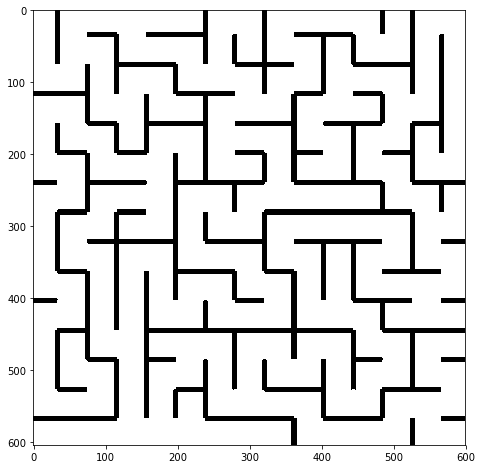

In [2]:
# load the map
le_map = mp.load_map('maze01.jpg')

# plotting
_, ax, = plt.subplots(figsize=(10, 8))
ax.imshow(le_map, cmap='Greys')
plt.show()

### Generate route through this maze

Generate a route, or load a pre-generated route through the maze

In [49]:
class RouteAction(Enum):
    LOAD = 0
    CREATE = 1
    
# route_action = RouteAction.CREATE
route_action = RouteAction.LOAD

# Generate new route if it hasn't already been made
if route_action == RouteAction.LOAD:
    # read route
    route_file = join(paths['routes'], 'maze01_route04.npz')
    route_items = np.load(route_file)
    state_history = route_items['state_history']
    process_model = route_items['process_model']
    Q = route_items['Q']
    dt = route_items['dt']
    print('Route loaded')
elif route_action == RouteAction.CREATE:
    # generate the route and get x,y position from it
    state_history, process_model, Q, dt = fl.generate_route(le_map, v=50)
    print('Route generated')

route = state_history[:, 1:3].astype('int')

Route loaded


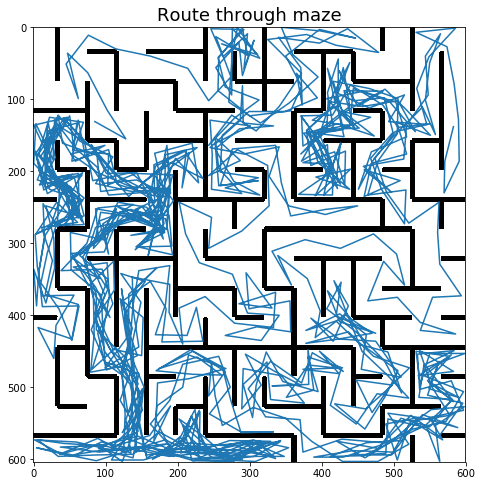

Save route (y/n)?n
Map not saved


In [50]:
# plotting
im = le_map.astype('float')

# plt.imshow(im, cmap='Greys')
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(im, cmap='Greys')
ax.plot(route[:, 1],route[:, 0])
plt.title('Route through maze', fontsize=18)
plt.show()

# to save
to_save = (input('Save route (y/n)?') == 'y')
if not to_save:
    print('Map not saved')
else:
    route_number = int(input('Enter route number: '))
    filepath = join(paths['routes'], 'maze01_route{:02d}'.format(route_number))
    np.savez(filepath,
             state_history=state_history,
             process_model=process_model,
             Q=Q,
             dt=dt)
    print('Route saved to' + filepath + '.npz')

### Perform particle filtering to zero in on this route

Process is:
1. Randomly sample a population of particles
2. Predict population positions based on known robot motion
3. Discount any particles that have gone through a wall
4. Resample to maintain the number of particles
5. Repeat steps 2 to 4, regenerating a new particle set any time that all the particles are blocked

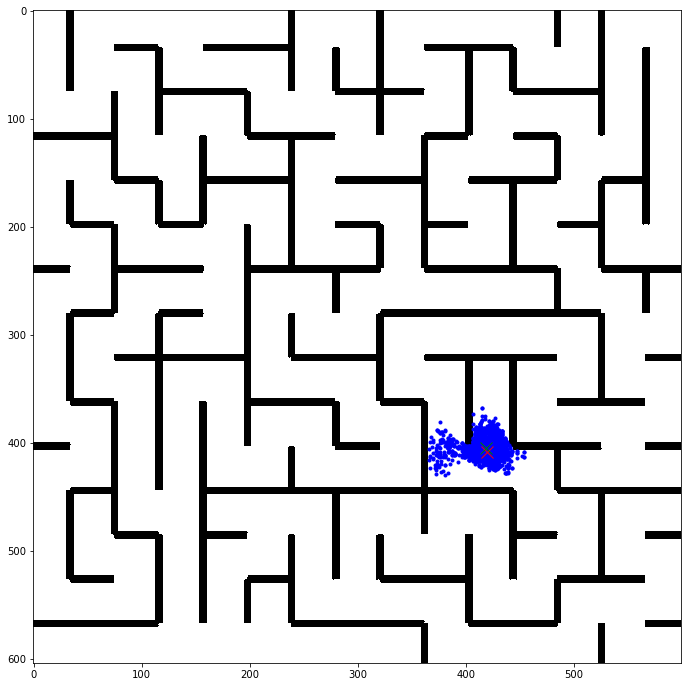

Mean and median prediction times per 10000 particles: 0.9251750946044922 0.9000009298324585
Mean and median update times per 10000 particles: 0.0019230598058456029 0.0


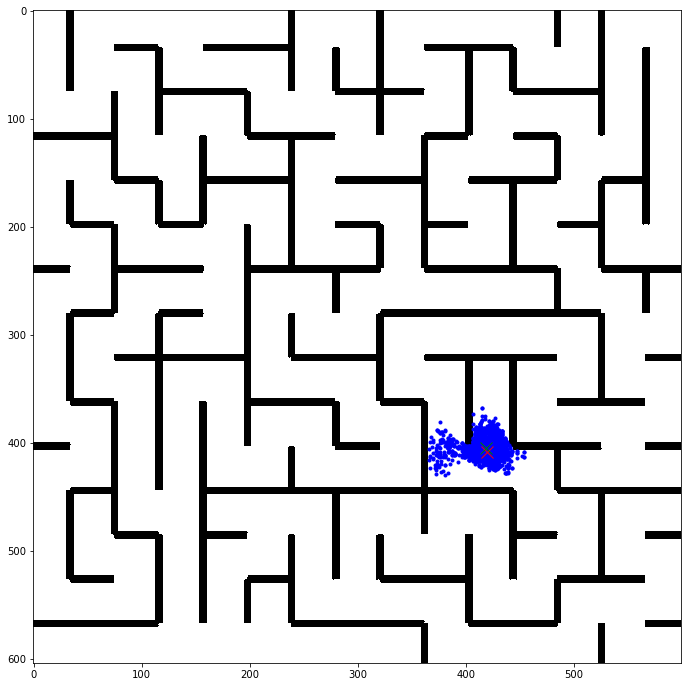

In [57]:
%matplotlib inline

# init population
n_particles = 2000

pop = fl.generate_particles(le_map, n_particles)

# CHEAT - put the first true position in a couple of particles
n_cheat = 0
pop[:n_cheat, :] = np.tile(state_history[0, :], (n_cheat, 1))

# Get state estimate
state_estimate, _ = fl.compute_state_estimate(pop)

# Get starting time
start_i = 0

# Setup visualisation
tic = time.time()
fig, ax = plt.subplots(figsize=(14, 12))
ax.imshow(im, cmap='Greys')
ax.plot(pop[:, 2], pop[:, 1], 'b.')
ax.plot(route[start_i, 1], route[start_i, 0], 'rx', markersize=12)
ax.plot(state_estimate[2], state_estimate[1], 'gx', markersize=12)
plt.title('Route through maze', fontsize=18)
display.display(plt.gcf())
toc =  time.time()
display_time = toc - tic

err = None

predict_time = []
update_time = []

n_updates_max = route.shape[0] - 1
n_updates = min(n_updates_max, 200)


# Perform prediction  
for i in range(start_i, n_updates):
    
    try:
    
        ax.clear()
        display.clear_output(wait=True)

        # Do update for next step
        if i != n_updates:

            u = process_model[i, :]

            tic = time.time()  
            pop = fl.predict(pop, u, Q, le_map, dt=dt) 
            toc = time.time()
            t_predict = toc - tic
            predict_time.append(t_predict)

            tic = time.time()
            pop = fl.update(pop)
            toc = time.time()
            t_update = toc - tic
            update_time.append(t_update)

        # Pause for effect
        time.sleep(max(0.2 - t_predict - t_update, 0))
        
        state_estimate, _ = fl.compute_state_estimate(pop)

        tic =  time.time()
        ax.imshow(im, cmap='Greys')
        ax.plot(pop[:, 2], pop[:, 1], 'b.')
        ax.plot(route[i+1, 1], route[i+1, 0], 'rx', markersize=12)
        ax.plot(state_estimate[2], state_estimate[1], 'gx', markersize=12)
        display.display(plt.gcf())
        toc =  time.time()
        display_time = toc - tic
        
    except ValueError as e:
        err = e
        print('Regenerating particle distribution')
        pop = fl.generate_particles(le_map, n_particles)


predict_time = np.array(predict_time) * 10000 / n_particles
update_time = np.array(update_time) * 10000 / n_particles

print('Mean and median prediction times per 10000 particles: {} {}'.
      format(np.mean(predict_time), np.median(predict_time)))
print('Mean and median update times per 10000 particles: {} {}'.
      format(np.mean(update_time), np.median(update_time)))